<a href="https://colab.research.google.com/github/vmjs1234/DECISION_TREE_AND_ENSEMBLE/blob/main/3)_adaboost_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## Define the AdaBoost Algorithm

In [2]:
class AdaBoost:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.alphas = []
        self.models = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Initialize weights
        w = np.full(n_samples, (1 / n_samples))

        for _ in range(self.n_estimators):
            # Train a weak classifier
            model = DecisionStump()
            min_error = float('inf')
            for feature_i in range(n_features):
                thresholds = np.unique(X[:, feature_i])
                for threshold in thresholds:
                    p = 1
                    predictions = np.ones(n_samples)
                    predictions[X[:, feature_i] < threshold] = -1
                    error = sum(w[y != predictions])
                    if error > 0.5:
                        error = 1 - error
                        p = -1
                    if error < min_error:
                        min_error = error
                        model.polarity = p
                        model.threshold = threshold
                        model.feature_index = feature_i

            # Calculate alpha
            EPS = 1e-10
            alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS))
            predictions = model.predict(X)
            # Update weights
            w *= np.exp(-alpha * y * predictions)
            w /= np.sum(w)

            # Save model and alpha
            self.models.append(model)
            self.alphas.append(alpha)

    def predict(self, X):
        clf_preds = [alpha * model.predict(X) for model, alpha in zip(self.models, self.alphas)]
        y_pred = np.sum(clf_preds, axis=0)
        return np.sign(y_pred)

class DecisionStump:
    def __init__(self):
        self.polarity = 1
        self.threshold = None
        self.feature_index = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_index]
        predictions = np.ones(n_samples)
        if self.polarity == 1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1
        return predictions


## Generate Synthetic Data

In [3]:
# Create a synthetic dataset
X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, random_state=42)
y = np.where(y == 0, -1, 1)  # Convert labels to {-1, 1}

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Train the AdaBoost Classifier

In [4]:
# Initialize and train AdaBoost classifier
clf = AdaBoost(n_estimators=10)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 95.00%


## Visualize Decision Boundaries

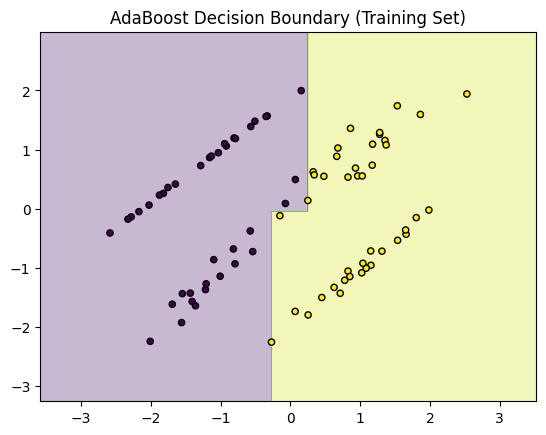

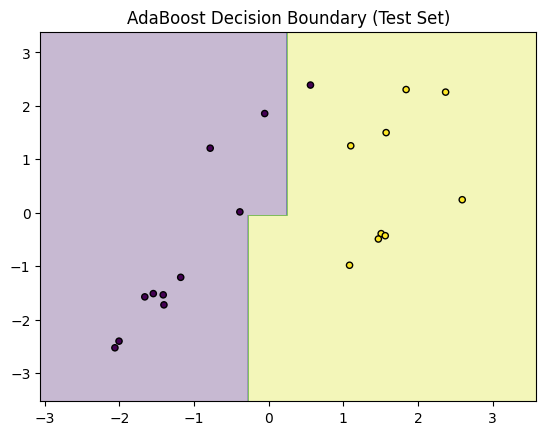

In [5]:
def plot_decision_boundary(clf, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', s=20)
    plt.title(title)
    plt.show()

# Plot decision boundary
plot_decision_boundary(clf, X_train, y_train, "AdaBoost Decision Boundary (Training Set)")
plot_decision_boundary(clf, X_test, y_test, "AdaBoost Decision Boundary (Test Set)")


## Visualize Model Performance Over Iterations

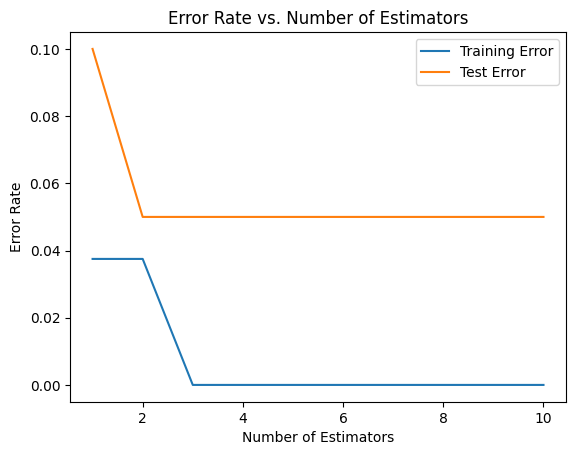

In [6]:
# Track training and test errors
train_errors = []
test_errors = []

for i in range(1, clf.n_estimators + 1):
    y_train_pred = np.sign(np.sum([alpha * model.predict(X_train) for alpha, model in zip(clf.alphas[:i], clf.models[:i])], axis=0))
    y_test_pred = np.sign(np.sum([alpha * model.predict(X_test) for alpha, model in zip(clf.alphas[:i], clf.models[:i])], axis=0))
    train_errors.append(1 - accuracy_score(y_train, y_train_pred))
    test_errors.append(1 - accuracy_score(y_test, y_test_pred))

# Plot errors
plt.plot(range(1, clf.n_estimators + 1), train_errors, label='Training Error')
plt.plot(range(1, clf.n_estimators + 1), test_errors, label='Test Error')
plt.xlabel('Number of Estimators')
plt.ylabel('Error Rate')
plt.title('Error Rate vs. Number of Estimators')
plt.legend()
plt.show()
